In [4]:
import pandas as pd
import numpy as np

from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords as sw
from nltk.tokenize import TweetTokenizer
import nltk
import string
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


stopwords = sw.words('english') + ["'d", "'ll", "'re", "'s", "'ve", 'doe', 'ha', "n't", 'sha', 'wa', 'wo']
IMAGE_PATH = 'images/'
SUBMISSIONS_PATH = 'submissions/'

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:

class CustomTokenizer(object):
    def __init__(self, tokenizer=TweetTokenizer(preserve_case=False), stopwords=stopwords):
        self.tokenizer = tokenizer
        self.lemmatizer = WordNetLemmatizer()
        self.wordDict = {'PAD':0}
        self.num_words = 1

    def word2idx(self, df, fit=True):
        tweets = []

        for index, row in df.iterrows():
            tokens=self.tokenizer.tokenize(row["full_text"])
            tweet = []

            for token in tokens:
                if token not in stopwords:
                    token = self.lemmatizer.lemmatize(token)

                    if (
                    token not in string.punctuation and
                    len(token) > 2
                    ):
                        if token not in self.wordDict and fit:
                            self.wordDict[token]=self.num_words
                            self.num_words+=1
                        elif token not in self.wordDict and not fit:
                            continue

                        tweet.append(self.wordDict[token])

            tweets.append(tweet)

        return tweets, self.wordDict

    def sequences_to_text(self, sequences):
        tweets = []
        for seq in sequences:
            tweet = []
            for token in seq:
                if token != 0:
                    tweet.append(list(self.wordDict.keys())[list(self.wordDict.values()).index(token)])
            tweets.append(tweet)
        return tweets

In [6]:
training_set = pd.read_json('../development.jsonl', lines=True)
test_set = pd.read_json('../evaluation.jsonl', lines=True)

In [7]:
tokenizer = CustomTokenizer()
X_train, wordDict = tokenizer.word2idx(training_set)
X_test, _ = tokenizer.word2idx(test_set, fit=False)

In [8]:
from tensorflow.keras.preprocessing import sequence

vocabulary_size = len(wordDict)

word_count = lambda tweet: len(tweet)
longest_tweet = max(X_train, key=word_count)
max_len = len(longest_tweet)

X = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

y = training_set["class"].to_numpy()

In [9]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, GlobalMaxPool1D

deep_inputs = Input(shape=(max_len,)) # Input

embedding = Embedding(vocabulary_size, 64, input_length=max_len)(deep_inputs) # Embeddings

lstm = LSTM(128, return_sequences=True, name='lstm_layer', dropout=0.1, recurrent_dropout=0.1)(embedding)

max_pool = GlobalMaxPool1D()(lstm)

dropout = Dropout(0.5)(max_pool)

dense = Dense(50, activation="relu")(dropout)

drop = Dropout(0.5)(dense)

x = Dense(1, activation="sigmoid")(drop)

model = Model(inputs=deep_inputs, outputs=x)

In [10]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

callback = [EarlyStopping(patience=2)]
batch_size = 64
num_epochs = 10

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs, callbacks=callback)

Epoch 1/10
1000/1000 [==============================] - 170s 170ms/step - loss: 0.2597 - accuracy: 0.8847 - val_loss: 0.1863 - val_accuracy: 0.9204

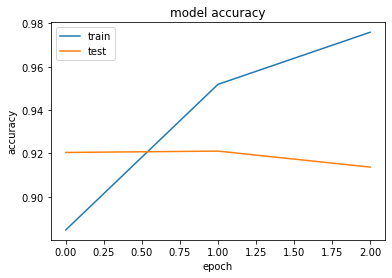

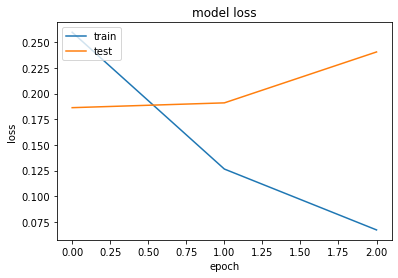

In [11]:
IMAGE_PATH = 'images/'

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
#plt.savefig(IMAGE_PATH + 'LSTM_acc')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
#plt.savefig(IMAGE_PATH + 'LSTM_l')
plt.show()

In [12]:
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Embedding, Convolution1D, MaxPool1D, Dropout, BatchNormalization, LSTM, Dense, concatenate

embedding_size = 64

input = Input(shape=(max_len, ))

embedding = Embedding(vocabulary_size, embedding_size, input_length=max_len) (input)

conv3 = Convolution1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (embedding)

conv5 = Convolution1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (embedding)

conv7 = Convolution1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (embedding)

conv9 = Convolution1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (embedding)

max_pool3 = MaxPool1D(pool_size=2)(conv3)

max_pool5 = MaxPool1D(pool_size=2)(conv5)

max_pool7 = MaxPool1D(pool_size=2)(conv7)

max_pool9 = MaxPool1D(pool_size=2)(conv9)

drop3 = Dropout(0.5)(max_pool3)

drop5 = Dropout(0.5)(max_pool5)

drop7 = Dropout(0.5)(max_pool7)

drop9 = Dropout(0.5)(max_pool9)

batch_norm3 = BatchNormalization()(drop3)

batch_norm5 = BatchNormalization()(drop5)

batch_norm7 = BatchNormalization()(drop7)

batch_norm9 = BatchNormalization()(drop9)

lstm3 = LSTM(128, dropout=0)(batch_norm3)

lstm5 = LSTM(128, dropout=0)(batch_norm5)

lstm7 = LSTM(128, dropout=0)(batch_norm7)

lstm9 = LSTM(128, dropout=0)(batch_norm9)

merge = concatenate([lstm3, lstm5, lstm7, lstm9])

output = Dense(1, activation='sigmoid')(merge)

model = Model(inputs=input, outputs=output)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 67)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 67, 64)       3864256     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 65, 128)      24704       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 63, 128)      41088       embedding_1[0][0]                
____________________________________________________________________________________________

In [13]:
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.model_selection import train_test_split


opt = optimizers.RMSprop(learning_rate=0.01, decay=0.1)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

callback = [EarlyStopping(patience=2, restore_best_weights=True)]
batch_size = 64
num_epochs = 10

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs, callbacks=callback)



Epoch 1/10
1000/1000 [==============================] - 196s 196ms/step - loss: 0.3147 - accuracy: 0.8783 - val_loss: 0.2492 - val_accuracy: 0.8913

In [14]:

history = model.fit(X, y,  batch_size=batch_size, epochs=num_epochs)

predictions = model.predict(X_test)
predictions = np.round(predictions.reshape(-1)).astype(int)
pred = pd.DataFrame()
pred.insert(0, "Predicted", predictions, True)
pred.to_csv('submission_LSTM.csv',sep=',', index_label='Id')



Epoch 1/10
1250/1250 [==============================] - 236s 189ms/step - loss: 0.2009 - accuracy: 0.9176